In [1]:
import xarray as xr
import numpy as np
import sys
sys.path.append('/home/563/rl5183/PhD-research/Functions')
import functions as func
from importlib import reload 
from scipy import signal 
import matplotlib.pyplot as plt
import seaborn
import cartopy.crs as ccrs
import climtas.io

In [2]:
# read in models 
multi_model = func.read_in_cmip_models('/g/data/eg3/mf3225/CMIP_TS/CMIP6/historical', 'r1i1p1f1', 'ts', '1850-01', '2015-01')
# Order models alphabetically 
multi_model = multi_model.sortby('model')
# Select out surface temperature data 
data = multi_model.ts

Model FGOALS-g3 has weird time


In [3]:
# Detrend temp data
data_dt = xr.apply_ufunc(func.detrend_2step, data, 
                             input_core_dims=[['time']],
                             output_core_dims=[['time']],
                             vectorize=True,
                             dask='parallelized')

data_dt = data_dt.transpose(*data.dims).chunk('auto').sel(time=slice('1900-01', '2014-12'))

In [ ]:
#check detrending worked 
#data.sel(model='ACCESS-CM2').mean(dim='lat').mean(dim='lon').plot()
#data_dt.sel(model='ACCESS-CM2').mean(dim='lat').mean(dim='lon').plot()

In [ ]:
# Calculate Nino3.4 index
#nino34_list = []
#for m in data_dt.model:
    #nino34_list.append(func.nino34_index(data_dt.sel(model=m), '1950-01', '1979-12'))
#nino34 = xr.concat(nino34_list, dim='model').chunk('auto')

In [4]:
nino34 = xr.open_dataarray('nino34_cmip6.nc').sel(time=slice('1900-01', '2014-12'))

In [5]:
# HadISST
hadisst_ds = xr.open_dataset('/g/data/w40/rl5183/hadisst.1870_2017_1.5x1.5.nc')
hadisst = hadisst_ds.sst
# Detrend 
hadisst_detrend = np.apply_along_axis(func.detrend_2step, 0, hadisst)
hadisst_dt = xr.DataArray(hadisst_detrend, coords=hadisst.coords, attrs=hadisst.attrs)

In [6]:
had_nino34 = func.nino34_index(hadisst_dt, '1950-01', '1979-12').sel(time=slice('1900-01', '2014-12'))

### Phase Locking

In [ ]:
# Phase locking
# seasonal_std = nino34.groupby('time.season').std(['time']).chunk('auto')

# Save as netcdf
# seasonal_std.to_netcdf('seasonal_nino_cmip6.nc')

In [7]:
seasonal_std = xr.open_dataarray('seasonal_nino_cmip6.nc')

In [8]:
# max in each column 
max_season = seasonal_std.max(dim='season')

/local/eg3/rl5183/tmp/ipykernel_3531970/4053888822.py:9: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('phase_lock_nino34_cmip6.jpg', bbox_inches='tight', dpi=300, quality=80, optimize=True, progressive=True)
/local/eg3/rl5183/tmp/ipykernel_3531970/4053888822.py:9: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "optimize" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('phase_lock_nino34_cmip6.jpg', bbox_inches='tight', dpi=300, quality=80, optimize=True, progressive=True)
/local/eg3/rl5183/tmp/ipykernel_3531970/4053888822.py:9: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "progressive" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('phase_lock_nino34_cmip6.jpg', bbox_inches='tight', dpi=300, quality=80, optimize=True, progressive=True)


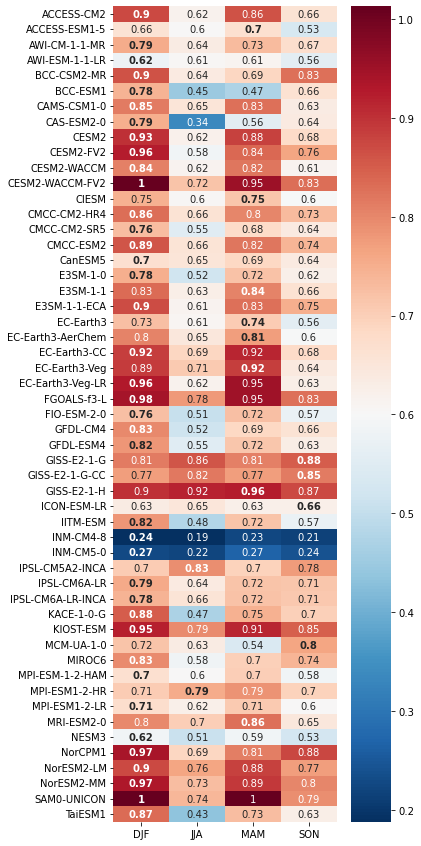

In [10]:
fig = plt.subplots(figsize=(5,15))
seaborn.heatmap(seasonal_std, mask=seasonal_std == max_season,
                annot=True, cmap='RdBu_r', 
                xticklabels=seasonal_std.season.values, yticklabels=seasonal_std.model.values)
seaborn.heatmap(seasonal_std, mask=seasonal_std != max_season,
                annot_kws={"weight": "bold"},
                annot=True, cmap='RdBu_r', cbar=False,
                xticklabels=seasonal_std.season.values, yticklabels=seasonal_std.model.values)
#plt.savefig('phase_lock_nino34_cmip6.jpg', bbox_inches='tight', dpi=300, quality=80, optimize=True, progressive=True)

### Zonal Distribution

In [11]:
# Zonal Distribution 
zon_std_list = []
for m in data_dt.model:
    zon_std_list.append(func.zonal_std(data_dt.sel(time=slice('1900-01','2014-12')).sel(model=m)))
    
zon_std = xr.DataArray(zon_std_list, dims=['model', 'lon'])
zon_std.coords['model'] = data_dt.model.values
zon_std.coords['lon'] = np.arange(160.5, 279.5, 1.5)

In [12]:
zon_std_had = xr.DataArray(func.zonal_std(hadisst_dt), dims=['lon'])
zon_std_had.coords['lon'] = np.arange(160.5, 279.5, 1.5)

/local/eg3/rl5183/tmp/ipykernel_3531970/2144172582.py:29: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('zonal_dist_cmip6.jpg', bbox_inches='tight', dpi=300, quality=80, optimize=True, progressive=True)
/local/eg3/rl5183/tmp/ipykernel_3531970/2144172582.py:29: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "optimize" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('zonal_dist_cmip6.jpg', bbox_inches='tight', dpi=300, quality=80, optimize=True, progressive=True)
/local/eg3/rl5183/tmp/ipykernel_3531970/2144172582.py:29: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "progressive" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('zonal_dist_cmip6.jpg', bbox_inches='tight', dpi=300, quality=80, optimize=True, progressive=True)


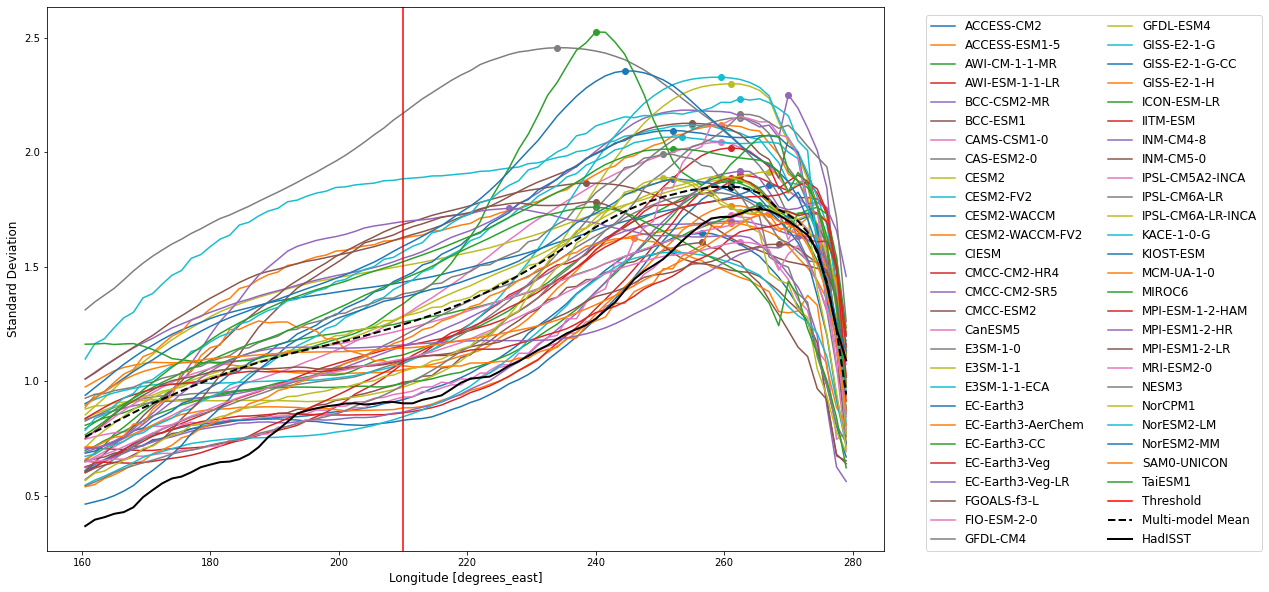

In [17]:
# Plot 
fig, ax = plt.subplots(figsize=(15,10))
lon = np.arange(160.5, 279.5, 1.5)
for m in zon_std.model:
    zon_std.sel(model=m).plot(ax=ax, label=f'{m.data}')
    ymax = np.max(zon_std.sel(model=m))
    xmax = lon[np.where(zon_std.sel(model=m) == ymax)]
    plt.scatter(xmax, ymax)

#150W = 210E
plt.axvline(210, 0, 1, color='red', label='Threshold')

#multi-model mean
zon_std_mmm = zon_std.mean(dim='model')
zon_std_mmm.plot(ax=ax, linestyle='--', color='black', linewidth='2', label='Multi-model Mean')
ymax = np.max(zon_std_mmm)
xmax = lon[np.where(zon_std_mmm == ymax)]
plt.scatter(xmax, ymax, color='black')

# HadISST 
zon_std_had.plot(color='black', linewidth='2', label='HadISST')
ymax = np.max(zon_std_had)
xmax = lon[np.where(zon_std_had == ymax)]
plt.scatter(xmax, ymax, color='black')

lgd = plt.legend(loc=(1.05, 0), prop={'size': 12}, ncol=2)
plt.xlabel('Longitude [degrees_east]', fontsize=12)
plt.ylabel('Standard Deviation', fontsize=12)
#plt.savefig('zonal_dist_cmip6.jpg', bbox_inches='tight', dpi=300, quality=80, optimize=True, progressive=True)

### El Nino, La Nina Composites 

In [47]:
elnino_list = []
lanina_list = []
for m in nino34.model:
    el, la = func.sst_comp(nino34.sel(model=m), data_dt.sel(model=m), 'DJF')
    elnino_list.append(el)
    lanina_list.append(la)

In [48]:
elnino = xr.concat(elnino_list, dim='model').chunk('auto')
lanina = xr.concat(lanina_list, dim='model').chunk('auto')

In [51]:
#climtas.io.to_netcdf_throttled(elnino, '/g/data/w40/rl5183/elnino_pattern_cmip6_1900_2014.nc')
#climtas.io.to_netcdf_throttled(lanina, '/g/data/w40/rl5183/lanina_pattern_cmip6_1900_2014.nc')

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [18]:
elnino = xr.open_dataarray('/g/data/w40/rl5183/elnino_pattern_cmip6_1900_2014.nc')
lanina = xr.open_dataarray('/g/data/w40/rl5183/lanina_pattern_cmip6_1900_2014.nc')

In [19]:
# Multi model means 
lanina_mmm = lanina.mean(dim='model')
elnino_mmm = elnino.mean(dim='model')

/local/eg3/rl5183/tmp/ipykernel_3531970/232284865.py:12: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('elnino_lanina_comp_cmip6.jpg', bbox_inches='tight', dpi=300, quality=80, optimize=True, progressive=True)
/local/eg3/rl5183/tmp/ipykernel_3531970/232284865.py:12: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "optimize" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('elnino_lanina_comp_cmip6.jpg', bbox_inches='tight', dpi=300, quality=80, optimize=True, progressive=True)
/local/eg3/rl5183/tmp/ipykernel_3531970/232284865.py:12: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "progressive" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('elnino_lanina_comp_cmip6.jpg', bbox_inches='tight', dpi=300, quality=80, optimize=True, progressive=True)


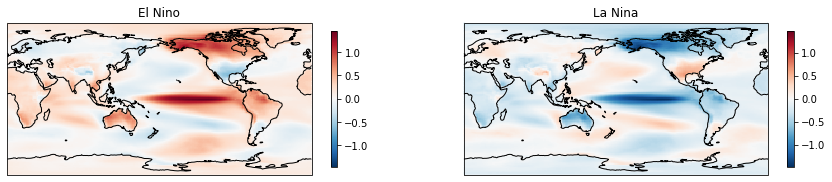

In [21]:
fig = plt.figure(figsize=(15,5)) 
ax = fig.add_subplot(121, projection=ccrs.PlateCarree(180))
im = elnino_mmm.plot(ax=ax, add_colorbar=False, transform=ccrs.PlateCarree())
cbar = plt.colorbar(im, ax=ax, shrink=0.5, pad=0.05)
ax.coastlines()
ax.set_title('El Nino')
ax = fig.add_subplot(122, projection=ccrs.PlateCarree(180))
im = lanina_mmm.plot(ax=ax, add_colorbar=False, transform=ccrs.PlateCarree())
cbar = plt.colorbar(im, ax=ax, shrink=0.5, pad=0.05)
ax.coastlines()
ax.set_title('La Nina')
#plt.savefig('elnino_lanina_comp_cmip6.jpg', bbox_inches='tight', dpi=300, quality=80, optimize=True, progressive=True)

### EP, CP Composites

In [7]:
had_nino3 = func.nino3_index(hadisst_dt, '1950-01', '1979-12').sel(time=slice('1900-01', '2014-12'))
had_nino4 = func.nino4_index(hadisst_dt, '1950-01', '1979-12').sel(time=slice('1900-01', '2014-12'))

In [8]:
had_EP = had_nino3 - 0.5*had_nino4
had_CP = had_nino4 - 0.5*had_nino3

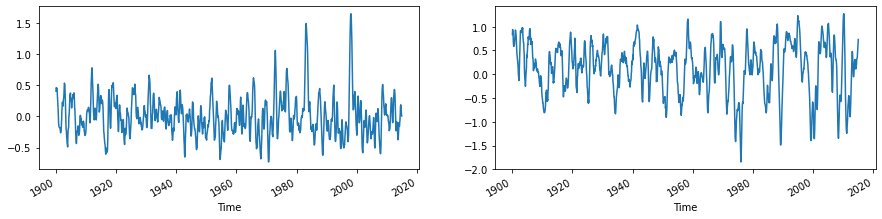

In [24]:
fig = plt.figure(figsize = (15,3))
ax = fig.add_subplot(121)
had_EP.plot(ax=ax)
ax  =fig.add_subplot(122)
had_CP.plot(ax=ax)

In [9]:
# Get EP and CP years 
seasonal_EP = func.seasonal_mean_nino_index(had_EP)
seasonal_CP = func.seasonal_mean_nino_index(had_CP)
djf_EP = seasonal_EP.sel(season='DJF')
djf_CP = seasonal_CP.sel(season='DJF')
EPs = djf_EP.where(djf_EP>0.5, drop=True)
CPs = djf_CP.where(djf_CP>0.5, drop=True)

In [10]:
# Find seasonal means for Hadisst 
func.seasonyear(hadisst_dt)
seasonal_hadisst = hadisst_dt.groupby('seasonyear').apply(func.seasonal_mean)
djf_hadisst = seasonal_hadisst.sel(season='DJF')

In [11]:
# Spatial patterns 
EP_pattern_hadisst = djf_hadisst.sel(seasonyear=EPs.seasonyear) - djf_hadisst.mean(dim='seasonyear')
CP_pattern_hadisst = djf_hadisst.sel(seasonyear=CPs.seasonyear) - djf_hadisst.mean(dim='seasonyear')

In [12]:
# Select out tropical pacific region
tropical_pacific_EP_hadisst = EP_pattern_hadisst.mean(dim='seasonyear').sel(lat=slice(-15,15)).sel(lon=slice(150,270))
tropical_pacific_CP_hadisst = CP_pattern_hadisst.mean(dim='seasonyear').sel(lat=slice(-15,15)).sel(lon=slice(150,270))
# Make 1d
hadisst_EP_1d = tropical_pacific_EP_hadisst.values.flatten()
hadisst_CP_1d = tropical_pacific_CP_hadisst.values.flatten()

In [ ]:
# Now with models 
# Nino3 Index
#nino3_list = []
#for m in data_dt.model:
    #nino3_list.append(func.nino3_index(data_dt.sel(model=m), '1950-01', '1979-12'))
#nino3 = xr.concat(nino3_list, dim='model').chunk('auto')
# Nino4 Index 
#nino4_list = []
#for m in data_dt.model:
    #nino4_list.append(func.nino4_index(data_dt.sel(model=m), '1950-01', '1979-12'))
#nino4 = xr.concat(nino4_list, dim='model').chunk('auto')
# Save as netCDF
#nino3.to_netcdf('nino3_cmip6.nc')
#nino4.to_netcdf('nino4_cmip6.nc')

In [29]:
nino3 = xr.open_dataarray('nino3_cmip6.nc').sel(time=slice('1900-01', '2014-12'))
nino4 = xr.open_dataarray('nino4_cmip6.nc').sel(time=slice('1900-01', '2014-12'))

In [30]:
# EP and CP indices 
EP = nino3 - 0.5*nino4
CP = nino4 - 0.5*nino3

In [31]:
func.seasonyear(data_dt)
seasonal_data = data_dt.groupby('seasonyear').apply(func.seasonal_mean)
djf_data = seasonal_data.sel(season='DJF')

In [32]:
def EP_CP_comp_count(EP, CP, djf_data):
    # Find EP and CP events 
    seasonal_EP = func.seasonal_mean_nino_index(EP)
    seasonal_CP = func.seasonal_mean_nino_index(CP)
    djf_EP = seasonal_EP.sel(season='DJF')
    djf_CP = seasonal_CP.sel(season='DJF')
    EPs = djf_EP.where(djf_EP>0.5, drop=True)
    CPs = djf_CP.where(djf_CP>0.5, drop=True)
    # Count EPs and CPs
    EP_count = len(EPs)
    CP_count = len(CPs)
    # Find mean SST patterns 
    EP_patterns = djf_data.sel(seasonyear=EPs.seasonyear) - djf_data.mean(dim='seasonyear')
    CP_patterns = djf_data.sel(seasonyear=CPs.seasonyear) - djf_data.mean(dim='seasonyear')
    EP_pattern = EP_patterns.mean(dim='seasonyear').chunk('auto')
    CP_pattern = CP_patterns.mean(dim='seasonyear').chunk('auto')
    return EP_count, CP_count, EP_pattern, CP_pattern

In [33]:
EP_pattern_list = []
CP_pattern_list = []
EP_count_list = []
CP_count_list = []
for m in EP.model:
    EP_count, CP_count, EP_pattern, CP_pattern = EP_CP_comp_count(EP.sel(model=m), CP.sel(model=m), djf_data.sel(model=m))
    EP_pattern_list.append(EP_pattern)
    CP_pattern_list.append(CP_pattern)
    EP_count_list.append(EP_count)
    CP_count_list.append(CP_count)

In [34]:
EP_pattern = xr.concat(EP_pattern_list, dim='model').chunk('auto')
CP_pattern = xr.concat(CP_pattern_list, dim='model').chunk('auto')

In [ ]:
#climtas.io.to_netcdf_throttled(EP_pattern, '/g/data/w40/rl5183/EP_pattern_cmip6_1900_2014.nc')
#climtas.io.to_netcdf_throttled(CP_pattern, '/g/data/w40/rl5183/CP_pattern_cmip6_1900_2014.nc')

In [13]:
EP_pattern = xr.open_dataarray('/g/data/w40/rl5183/EP_pattern_cmip6_1900_2014.nc')
CP_pattern = xr.open_dataarray('/g/data/w40/rl5183/CP_pattern_cmip6_1900_2014.nc')

/local/eg3/rl5183/tmp/ipykernel_3531970/2619163193.py:24: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('EP_CP_comp_cmip6.jpg', bbox_inches='tight', dpi=300, quality=80, optimize=True, progressive=True)
/local/eg3/rl5183/tmp/ipykernel_3531970/2619163193.py:24: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "optimize" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('EP_CP_comp_cmip6.jpg', bbox_inches='tight', dpi=300, quality=80, optimize=True, progressive=True)
/local/eg3/rl5183/tmp/ipykernel_3531970/2619163193.py:24: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "progressive" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('EP_CP_comp_cmip6.jpg', bbox_inches='tight', dpi=300, quality=80, optimize=True, progressive=True)


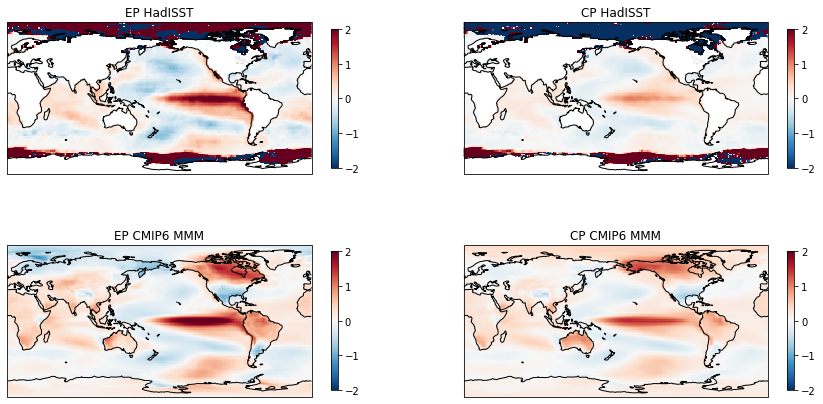

In [37]:
# PLot spatial patterns 

fig = plt.figure(figsize = (15,7.5)) 
ax = fig.add_subplot(221, projection=ccrs.PlateCarree(180))
im = EP_pattern_hadisst.mean(dim='seasonyear').plot(ax=ax, vmin=-2, vmax=2, cmap='RdBu_r', add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('EP HadISST')
cbar = plt.colorbar(im, ax=ax, shrink=0.75, pad=0.05)
ax = fig.add_subplot(222, projection=ccrs.PlateCarree(180))
im = CP_pattern_hadisst.mean(dim='seasonyear').plot(ax=ax, vmin=-2, vmax=2, cmap='RdBu_r', add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('CP HadISST')
cbar = plt.colorbar(im, ax=ax, shrink=0.75, pad=0.05)
ax = fig.add_subplot(223, projection=ccrs.PlateCarree(180))
im = EP_pattern.mean(dim='model').plot(ax=ax, vmin=-2, vmax=2, cmap='RdBu_r', add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('EP CMIP6 MMM')
cbar = plt.colorbar(im, ax=ax, shrink=0.75, pad=0.05)
ax = fig.add_subplot(224, projection=ccrs.PlateCarree(180))
im = CP_pattern.mean(dim='model').plot(ax=ax, vmin=-2, vmax=2, cmap='RdBu_r', add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('CP CMIP6 MMM')
cbar = plt.colorbar(im, ax=ax, shrink=0.75, pad=0.05)
#plt.savefig('EP_CP_comp_cmip6.jpg', bbox_inches='tight', dpi=300, quality=80, optimize=True, progressive=True)

In [14]:
model_names = EP_pattern.model.values

In [39]:
EP_dict = dict(zip(model_names, EP_count_list))
CP_dict = dict(zip(model_names, CP_count_list))

In [54]:
CP_dict

{'ACCESS-CM2': 19,
 'ACCESS-ESM1-5': 25,
 'AWI-CM-1-1-MR': 20,
 'AWI-ESM-1-1-LR': 19,
 'BCC-CSM2-MR': 31,
 'BCC-ESM1': 16,
 'CAMS-CSM1-0': 33,
 'CAS-ESM2-0': 34,
 'CESM2': 30,
 'CESM2-FV2': 35,
 'CESM2-WACCM': 17,
 'CESM2-WACCM-FV2': 20,
 'CIESM': 30,
 'CMCC-CM2-HR4': 33,
 'CMCC-CM2-SR5': 29,
 'CMCC-ESM2': 31,
 'CanESM5': 24,
 'E3SM-1-0': 22,
 'E3SM-1-1': 22,
 'E3SM-1-1-ECA': 31,
 'EC-Earth3': 33,
 'EC-Earth3-AerChem': 36,
 'EC-Earth3-CC': 28,
 'EC-Earth3-Veg': 34,
 'EC-Earth3-Veg-LR': 32,
 'FGOALS-f3-L': 21,
 'FIO-ESM-2-0': 24,
 'GFDL-CM4': 26,
 'GFDL-ESM4': 33,
 'GISS-E2-1-G': 36,
 'GISS-E2-1-G-CC': 37,
 'GISS-E2-1-H': 23,
 'ICON-ESM-LR': 17,
 'IITM-ESM': 17,
 'INM-CM4-8': 0,
 'INM-CM5-0': 3,
 'IPSL-CM5A2-INCA': 35,
 'IPSL-CM6A-LR': 21,
 'IPSL-CM6A-LR-INCA': 22,
 'KACE-1-0-G': 31,
 'KIOST-ESM': 25,
 'MCM-UA-1-0': 35,
 'MIROC6': 33,
 'MPI-ESM-1-2-HAM': 24,
 'MPI-ESM1-2-HR': 28,
 'MPI-ESM1-2-LR': 38,
 'MRI-ESM2-0': 37,
 'NESM3': 40,
 'NorCPM1': 26,
 'NorESM2-LM': 35,
 'NorESM2-MM': 13,

In [15]:
def tropical_pacific_pattern_corr(model_pattern, ob_pattern):
    # Select out region
    tropical_pacific = model_pattern.sel(lat=slice(-15,15)).sel(lon=slice(150,270))
    # Flatten
    d1 = tropical_pacific.values.flatten()
    # Calculate correlation
    from scipy.stats import pearsonr
    corr = pearsonr(ob_pattern, d1)
    #print(f'model {m} works')
    return corr[0]

In [16]:
# Remove models with no events 
EP_pattern = EP_pattern.drop_sel(model=['INM-CM4-8', 'INM-CM5-0', 'MCM-UA-1-0', 'MPI-ESM1-2-HR'])

In [17]:
EP_pattern_corr = []
for m in EP_pattern.model:
    EP_pattern_corr.append(tropical_pacific_pattern_corr(EP_pattern.sel(model=m), hadisst_EP_1d))

In [67]:
# Remove models with no events 
CP_pattern = CP_pattern.drop_sel(model='INM-CM4-8')

In [18]:
# For same size array 
CP_pattern = CP_pattern.drop_sel(model=['INM-CM4-8', 'INM-CM5-0', 'MCM-UA-1-0', 'MPI-ESM1-2-HR'])

In [19]:
CP_pattern_corr = []
for m in CP_pattern.model:
    CP_pattern_corr.append(tropical_pacific_pattern_corr(CP_pattern.sel(model=m), hadisst_CP_1d))

In [20]:
np.set_printoptions(precision=2)

In [23]:
EP_patter_corr_np = np.array(EP_pattern_corr)
EP_patter_corr_np

array([ 0.94,  0.88,  0.86,  0.59,  0.86,  0.91,  0.92,  0.86,  0.92,
        0.91,  0.89,  0.95,  0.86,  0.93,  0.88,  0.92,  0.85,  0.94,
        0.55,  0.85,  0.91,  0.92,  0.97,  0.96,  0.88,  0.96,  0.92,
        0.95,  0.9 ,  0.91,  0.89,  0.96,  0.8 ,  0.93, -0.09,  0.91,
        0.92, -0.42,  0.93,  0.94,  0.88,  0.81,  0.95,  0.94,  0.89,
        0.92,  0.93,  0.92,  0.96])

In [24]:
CP_patter_corr_np = np.array(CP_pattern_corr)
CP_patter_corr_np

array([0.88, 0.68, 0.9 , 0.61, 0.76, 0.79, 0.85, 0.74, 0.9 , 0.9 , 0.9 ,
       0.93, 0.95, 0.9 , 0.9 , 0.92, 0.81, 0.89, 0.9 , 0.88, 0.91, 0.93,
       0.92, 0.91, 0.92, 0.92, 0.91, 0.94, 0.91, 0.85, 0.85, 0.9 , 0.57,
       0.87, 0.72, 0.85, 0.86, 0.92, 0.89, 0.93, 0.92, 0.91, 0.91, 0.89,
       0.89, 0.89, 0.87, 0.87, 0.92])

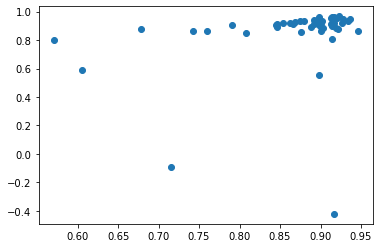

In [25]:
plt.scatter(CP_patter_corr_np, EP_patter_corr_np)

### Phase locking with Nino3 and Nino4

In [46]:
seasonal_std_3 = nino3.groupby('time.season').std(['time'])
seasonal_std_4 = nino4.groupby('time.season').std(['time'])

In [47]:
# max in each column 
max_season_3 = seasonal_std_3.max(dim='season')
max_season_4 = seasonal_std_4.max(dim='season')

/local/eg3/rl5183/tmp/ipykernel_3531970/1279301786.py:9: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('phase_lock_nino3_cmip6.jpg', bbox_inches='tight', dpi=300, quality=80, optimize=True, progressive=True)
/local/eg3/rl5183/tmp/ipykernel_3531970/1279301786.py:9: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "optimize" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('phase_lock_nino3_cmip6.jpg', bbox_inches='tight', dpi=300, quality=80, optimize=True, progressive=True)
/local/eg3/rl5183/tmp/ipykernel_3531970/1279301786.py:9: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "progressive" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('phase_lock_nino3_cmip6.jpg', bbox_inches='tight', dpi=300, quality=80, optimize=True, progressive=True)


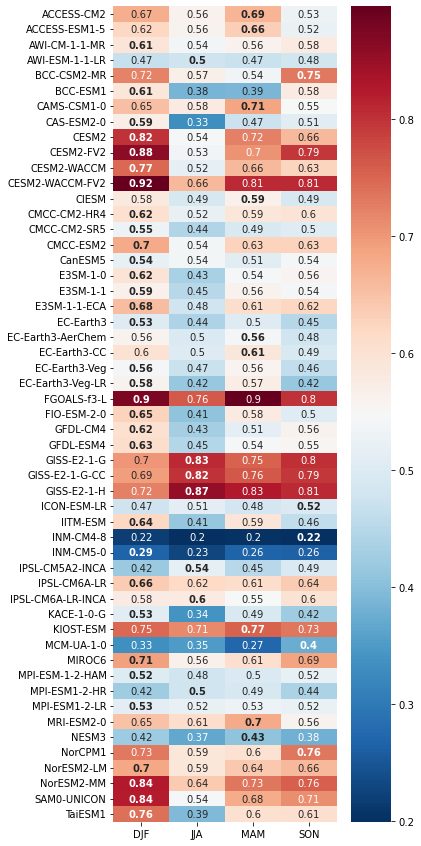

In [49]:
fig = plt.subplots(figsize=(5,15))
seaborn.heatmap(seasonal_std_3, mask=seasonal_std_3 == max_season_3,
                annot=True, cmap='RdBu_r', 
                xticklabels=seasonal_std_3.season.values, yticklabels=seasonal_std_3.model.values)
seaborn.heatmap(seasonal_std_3, mask=seasonal_std_3 != max_season_3,
                annot_kws={"weight": "bold"},
                annot=True, cmap='RdBu_r', cbar=False,
                xticklabels=seasonal_std_3.season.values, yticklabels=seasonal_std_3.model.values)
#plt.savefig('phase_lock_nino3_cmip6.jpg', bbox_inches='tight', dpi=300, quality=80, optimize=True, progressive=True)

/local/eg3/rl5183/tmp/ipykernel_3531970/598778371.py:9: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('phase_lock_nino4_cmip6.jpg', bbox_inches='tight', dpi=300, quality=80, optimize=True, progressive=True)
/local/eg3/rl5183/tmp/ipykernel_3531970/598778371.py:9: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "optimize" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('phase_lock_nino4_cmip6.jpg', bbox_inches='tight', dpi=300, quality=80, optimize=True, progressive=True)
/local/eg3/rl5183/tmp/ipykernel_3531970/598778371.py:9: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "progressive" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('phase_lock_nino4_cmip6.jpg', bbox_inches='tight', dpi=300, quality=80, optimize=True, progressive=True)


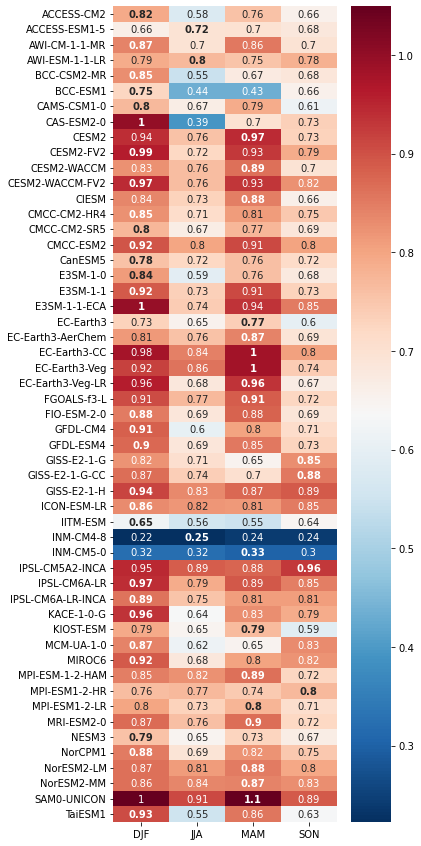

In [50]:
fig = plt.subplots(figsize=(5,15))
seaborn.heatmap(seasonal_std_4, mask=seasonal_std_4 == max_season_4,
                annot=True, cmap='RdBu_r', 
                xticklabels=seasonal_std_4.season.values, yticklabels=seasonal_std_4.model.values)
seaborn.heatmap(seasonal_std_4, mask=seasonal_std_4 != max_season_4,
                annot_kws={"weight": "bold"},
                annot=True, cmap='RdBu_r', cbar=False,
                xticklabels=seasonal_std_4.season.values, yticklabels=seasonal_std_4.model.values)
#plt.savefig('phase_lock_nino4_cmip6.jpg', bbox_inches='tight', dpi=300, quality=80, optimize=True, progressive=True)

### INM

In [32]:
inm_cm4_zon = func.zonal_std(data_dt.sel(time=slice('1900-01','2014-12')).sel(model='INM-CM4-8'))
inm_cm5_zon = func.zonal_std(data_dt.sel(time=slice('1900-01','2014-12')).sel(model='INM-CM5-0'))

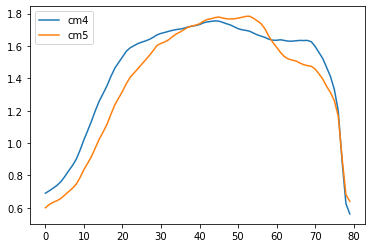

In [35]:
plt.plot(inm_cm4_zon, label='cm4')
plt.plot(inm_cm5_zon, label='cm5')
plt.legend()